In [309]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
from sklearn import linear_model

from sklearn.preprocessing import StandardScaler
from darts import TimeSeries
from fbprophet import Prophet

#util functions
from utils.utils import *

In [310]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [311]:
train.describe()

,Average
count,544.000000
mean,100.660317
std,13.711767
min,64.171250
25%,89.386429
50%,102.886230
75%,111.793036
max,131.453333


In [312]:
train.head()

,WeekEnding_Date,Kolkata_Average_Price,Kolkata_Ref_Price,Bangalore_Average_Price,Bangalore_Ref_Price,Cochin_Average_Price,Cochin_Ref_Price,Darjeeling_Average_Price,Darjeeling_Ref_Price,Ernakulam_Average_Price,Ernakulam_Ref_Price,Siliguri_Average_Price,Siliguri_Ref_Price,Guwahati_Average_Price,Guwahati_Ref_Price,Average
0,03/01/09,99.01,79.79,N.S.,76.19,84.02,70.07,81.66,57.83,68.94,51.67,70.74,53.88,65.55,46.75,69.700000
1,10/01/09,97.74,78.73,87.48,73.97,82.72,68.17,83.31,58.02,67.24,52.23,70.47,53.39,67.39,46.84,70.550000
2,17/01/09,95.95,71.01,87.66,71.01,80.58,67.16,82.25,57.49,69.64,52.48,71.66,53.18,69.51,48.04,69.830000
3,24/01/09,94.14,73.38,85.69,65.66,N.S.,65.57,80.87,54.59,N.S.,53.43,71.12,52.07,69.14,48.5,67.846667
4,31/01/09,91.45,70.39,N.S.,64.99,79.27,62.09,80.76,57.06,69.65,53.38,72.3,52.5,69.39,50.33,67.196923


In [313]:
train.isna().sum()

WeekEnding_Date             0
Kolkata_Average_Price       0
Kolkata_Ref_Price           2
Bangalore_Average_Price     0
Bangalore_Ref_Price         2
Cochin_Average_Price        0
Cochin_Ref_Price            3
Darjeeling_Average_Price    0
Darjeeling_Ref_Price        2
Ernakulam_Average_Price     0
Ernakulam_Ref_Price         1
Siliguri_Average_Price      1
Siliguri_Ref_Price          1
Guwahati_Average_Price      0
Guwahati_Ref_Price          0
Average                     0
dtype: int64

In [314]:
# len(train)
train.columns

Index(['WeekEnding_Date', 'Kolkata_Average_Price', 'Kolkata_Ref_Price',
       'Bangalore_Average_Price', 'Bangalore_Ref_Price',
       'Cochin_Average_Price', 'Cochin_Ref_Price', 'Darjeeling_Average_Price',
       'Darjeeling_Ref_Price', 'Ernakulam_Average_Price',
       'Ernakulam_Ref_Price', 'Siliguri_Average_Price', 'Siliguri_Ref_Price',
       'Guwahati_Average_Price', 'Guwahati_Ref_Price', 'Average'],
      dtype='object')

## the problem in hand seems to be that of timeseries
1. predict/forecast rates for the average/ref price 

### Problem 1:
input : **date**
output : **avg price**


## EDA , Impute missing values

### Since we know the avg column is the average of the cols 1:-1, we can use the formula to fill missing values

In [321]:
#convert date column to datetime
# train['WeekEnding_Date']=train['WeekEnding_Date'].apply(lambda x:'20{}-{}-{}'.format(x.split('/')[-1],x.split('/')[1],x.split('/')[0]))
train['WeekEnding_Date']=pd.to_datetime(train['WeekEnding_Date'])
# year = train['WeekEnding_Date'].apply(lambda x:x.year).tolist()
# month = train['WeekEnding_Date'].apply(lambda x:x.month).tolist()
# day = train['WeekEnding_Date'].apply(lambda x:x.day).tolist()


#sort by ascending date
train.sort_values(by=['WeekEnding_Date']).reset_index(drop=True)

,WeekEnding_Date,Kolkata_Average_Price,Kolkata_Ref_Price,Bangalore_Average_Price,Bangalore_Ref_Price,Cochin_Average_Price,Cochin_Ref_Price,Darjeeling_Average_Price,Darjeeling_Ref_Price,Ernakulam_Average_Price,Ernakulam_Ref_Price,Siliguri_Average_Price,Siliguri_Ref_Price,Guwahati_Average_Price,Guwahati_Ref_Price,Average
0,2009-01-08,120.93,97.27,112.08,92.36,105.19,87.63,N.S.,72.88,69.64,67.21,76.8,68.9,71.04,65.9,85.217692
1,2009-01-17,95.95,71.01,87.66,71.01,80.58,67.16,82.25,57.49,69.64,52.48,71.66,53.18,69.51,48.04,69.830000
2,2009-01-24,94.14,73.38,85.69,65.66,N.S.,65.57,80.87,54.59,N.S.,53.43,71.12,52.07,69.14,48.5,67.846667
3,2009-01-31,91.45,70.39,N.S.,64.99,79.27,62.09,80.76,57.06,69.65,53.38,72.3,52.5,69.39,50.33,67.196923
4,2009-02-05,126.49,95.14,122.25,87.51,118.95,86.36,87.37,59.05,85.14,56.17,83.31,55.35,79.73,53.5,85.451429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,2019-08-06,151.61,156.67,146.91,153.37,147.83,145.44,120.12,112.83,92.16,76.98,105.16,91.57,84.63,67.13,118.029286
540,2019-09-02,124.27,119.08,120.36,104.53,115.83,103.48,124.53,123.73,97.97,94.85,103.63,101.46,88.44,73.91,106.862143
541,2019-09-03,115.79,NS,NS,99.3,107.78,92.72,121.82,121.39,100.44,93.96,106.52,103.78,92.33,71.05,102.240000
542,2019-11-05,152.57,165.65,134.76,146.06,149.81,134.17,122.98,115.81,98.29,81.65,109.36,94.33,89.81,70.66,118.993571


In [322]:
# plt.show()

In [323]:
# [x for x in train[cols[2]].tolist() if not re.match(r'[a-zA-Z]',str(x))]

In [324]:
### lets get all sorts of null values out and change dtype of rest of them to float

# train['Kolkata_Average_Price'] = train['Kolkata_Average_Price'].apply(lambda x:float(x) if not re.match(r'[a-zA-Z]',x) else None)
cols = ['Kolkata_Average_Price','Kolkata_Ref_Price',
        'Bangalore_Average_Price', 'Bangalore_Ref_Price',
        'Cochin_Average_Price', 'Cochin_Ref_Price',
        'Darjeeling_Average_Price','Darjeeling_Ref_Price', 
        'Ernakulam_Average_Price','Ernakulam_Ref_Price', 
        'Siliguri_Average_Price', 'Siliguri_Ref_Price',
        'Guwahati_Average_Price', 'Guwahati_Ref_Price']
preprocess(train,cols)

,WeekEnding_Date,Kolkata_Average_Price,Kolkata_Ref_Price,Bangalore_Average_Price,Bangalore_Ref_Price,Cochin_Average_Price,Cochin_Ref_Price,Darjeeling_Average_Price,Darjeeling_Ref_Price,Ernakulam_Average_Price,Ernakulam_Ref_Price,Siliguri_Average_Price,Siliguri_Ref_Price,Guwahati_Average_Price,Guwahati_Ref_Price,Average
0,2009-03-01,99.01,79.79,NaN,76.19,84.02,70.07,81.66,57.83,68.94,51.67,70.74,53.88,65.55,46.75,69.700000
1,2009-10-01,97.74,78.73,87.48,73.97,82.72,68.17,83.31,58.02,67.24,52.23,70.47,53.39,67.39,46.84,70.550000
2,2009-01-17,95.95,71.01,87.66,71.01,80.58,67.16,82.25,57.49,69.64,52.48,71.66,53.18,69.51,48.04,69.830000
3,2009-01-24,94.14,73.38,85.69,65.66,NaN,65.57,80.87,54.59,NaN,53.43,71.12,52.07,69.14,48.50,67.846667
4,2009-01-31,91.45,70.39,NaN,64.99,79.27,62.09,80.76,57.06,69.65,53.38,72.30,52.50,69.39,50.33,67.196923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,2019-11-05,152.57,165.65,134.76,146.06,149.81,134.17,122.98,115.81,98.29,81.65,109.36,94.33,89.81,70.66,118.993571
540,2019-05-18,147.74,159.89,134.50,146.36,148.81,142.88,122.98,113.00,96.47,78.46,111.36,90.39,90.96,66.68,117.891429
541,2019-05-25,149.69,155.28,134.29,142.67,147.25,149.11,122.78,111.20,94.61,77.33,109.20,92.87,87.72,66.49,117.177857
542,2019-01-06,144.51,150.81,138.45,151.35,149.70,151.40,122.82,111.12,93.01,77.14,109.69,91.66,86.60,68.00,117.590000


In [325]:
train.isna().sum()

WeekEnding_Date              0
Kolkata_Average_Price       40
Kolkata_Ref_Price           42
Bangalore_Average_Price     47
Bangalore_Ref_Price         49
Cochin_Average_Price        45
Cochin_Ref_Price            49
Darjeeling_Average_Price    37
Darjeeling_Ref_Price        38
Ernakulam_Average_Price     15
Ernakulam_Ref_Price         17
Siliguri_Average_Price      21
Siliguri_Ref_Price          23
Guwahati_Average_Price       9
Guwahati_Ref_Price           9
Average                      0
dtype: int64

In [326]:
train.sort_values(by=['WeekEnding_Date']).reset_index(drop=True)

,WeekEnding_Date,Kolkata_Average_Price,Kolkata_Ref_Price,Bangalore_Average_Price,Bangalore_Ref_Price,Cochin_Average_Price,Cochin_Ref_Price,Darjeeling_Average_Price,Darjeeling_Ref_Price,Ernakulam_Average_Price,Ernakulam_Ref_Price,Siliguri_Average_Price,Siliguri_Ref_Price,Guwahati_Average_Price,Guwahati_Ref_Price,Average
0,2009-01-08,120.93,97.27,112.08,92.36,105.19,87.63,NaN,72.88,69.64,67.21,76.80,68.90,71.04,65.90,85.217692
1,2009-01-17,95.95,71.01,87.66,71.01,80.58,67.16,82.25,57.49,69.64,52.48,71.66,53.18,69.51,48.04,69.830000
2,2009-01-24,94.14,73.38,85.69,65.66,NaN,65.57,80.87,54.59,NaN,53.43,71.12,52.07,69.14,48.50,67.846667
3,2009-01-31,91.45,70.39,NaN,64.99,79.27,62.09,80.76,57.06,69.65,53.38,72.30,52.50,69.39,50.33,67.196923
4,2009-02-05,126.49,95.14,122.25,87.51,118.95,86.36,87.37,59.05,85.14,56.17,83.31,55.35,79.73,53.50,85.451429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,2019-08-06,151.61,156.67,146.91,153.37,147.83,145.44,120.12,112.83,92.16,76.98,105.16,91.57,84.63,67.13,118.029286
540,2019-09-02,124.27,119.08,120.36,104.53,115.83,103.48,124.53,123.73,97.97,94.85,103.63,101.46,88.44,73.91,106.862143
541,2019-09-03,115.79,NaN,NaN,99.30,107.78,92.72,121.82,121.39,100.44,93.96,106.52,103.78,92.33,71.05,102.240000
542,2019-11-05,152.57,165.65,134.76,146.06,149.81,134.17,122.98,115.81,98.29,81.65,109.36,94.33,89.81,70.66,118.993571


In [329]:
train = fill_null(train)



column : Kolkata_Average_Price
idx : 0
replacing row 40 on column Kolkata_Average_Price and value 79.83461531999978
replacing row 68 on column Kolkata_Average_Price and value 88.86999999999989
column : Kolkata_Ref_Price
idx : 1
replacing row 7 on column Kolkata_Ref_Price and value 65.19461532000003
replacing row 77 on column Kolkata_Ref_Price and value 83.67230765999989
replacing row 111 on column Kolkata_Ref_Price and value 85.90923077999946
replacing row 200 on column Kolkata_Ref_Price and value 106.9746156000001
column : Bangalore_Average_Price
idx : 2
replacing row 0 on column Bangalore_Average_Price and value 69.70000000000016
replacing row 3 on column Bangalore_Average_Price and value 67.19692312000006
replacing row 9 on column Bangalore_Average_Price and value 73.63153843999999
replacing row 83 on column Bangalore_Average_Price and value 73.0999999999998
replacing row 262 on column Bangalore_Average_Price and value 88.45307688000003
replacing row 429 on column Bangalore_Average_

In [330]:
train.sort_values(by=['WeekEnding_Date']).reset_index(drop=True)

,WeekEnding_Date,Kolkata_Average_Price,Kolkata_Ref_Price,Bangalore_Average_Price,Bangalore_Ref_Price,Cochin_Average_Price,Cochin_Ref_Price,Darjeeling_Average_Price,Darjeeling_Ref_Price,Ernakulam_Average_Price,Ernakulam_Ref_Price,Siliguri_Average_Price,Siliguri_Ref_Price,Guwahati_Average_Price,Guwahati_Ref_Price,Average
0,2009-01-08,120.93,97.27,112.080000,92.36,105.19,87.63,85.217692,72.88,69.64,67.21,76.80,68.90,71.04,65.90,85.217692
1,2009-01-17,95.95,71.01,87.660000,71.01,80.58,67.16,82.250000,57.49,69.64,52.48,71.66,53.18,69.51,48.04,69.830000
2,2009-01-31,91.45,70.39,67.196923,64.99,79.27,62.09,80.760000,57.06,69.65,53.38,72.30,52.50,69.39,50.33,67.196923
3,2009-02-05,126.49,95.14,122.250000,87.51,118.95,86.36,87.370000,59.05,85.14,56.17,83.31,55.35,79.73,53.50,85.451429
4,2009-02-14,87.95,67.81,79.980000,62.50,78.25,61.27,83.920000,57.66,69.93,51.80,70.90,53.47,65.14,49.76,67.167143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,2019-06-04,118.77,119.74,175.020000,125.75,152.77,165.07,122.240000,122.63,98.92,94.16,108.50,107.07,91.85,67.93,119.315714
437,2019-08-06,151.61,156.67,146.910000,153.37,147.83,145.44,120.120000,112.83,92.16,76.98,105.16,91.57,84.63,67.13,118.029286
438,2019-09-02,124.27,119.08,120.360000,104.53,115.83,103.48,124.530000,123.73,97.97,94.85,103.63,101.46,88.44,73.91,106.862143
439,2019-11-05,152.57,165.65,134.760000,146.06,149.81,134.17,122.980000,115.81,98.29,81.65,109.36,94.33,89.81,70.66,118.993571


In [331]:
train.isna().sum()
train = train.dropna()


### all null values are removed. Now  lets look at this as a time series problem

In [332]:

train.isna().sum()

WeekEnding_Date             0
Kolkata_Average_Price       0
Kolkata_Ref_Price           0
Bangalore_Average_Price     0
Bangalore_Ref_Price         0
Cochin_Average_Price        0
Cochin_Ref_Price            0
Darjeeling_Average_Price    0
Darjeeling_Ref_Price        0
Ernakulam_Average_Price     0
Ernakulam_Ref_Price         0
Siliguri_Average_Price      0
Siliguri_Ref_Price          0
Guwahati_Average_Price      0
Guwahati_Ref_Price          0
Average                     0
dtype: int64

In [333]:
test = preprocess(test,cols)

In [336]:
# test['WeekEnding_Date']=test['WeekEnding_Date'].apply(lambda x:'20{}-{}-{}'.format(x.split('/')[-1],x.split('/')[1],x.split('/')[0]))
test['WeekEnding_Date']=pd.to_datetime(test['WeekEnding_Date'])
# test_year = test['WeekEnding_Date'].apply(lambda x:x.year).tolist()
# test_month = test['WeekEnding_Date'].apply(lambda x:x.month).tolist()
# test_day = test['WeekEnding_Date'].apply(lambda x:x.day).tolist()


In [337]:
# test.isna().sum()


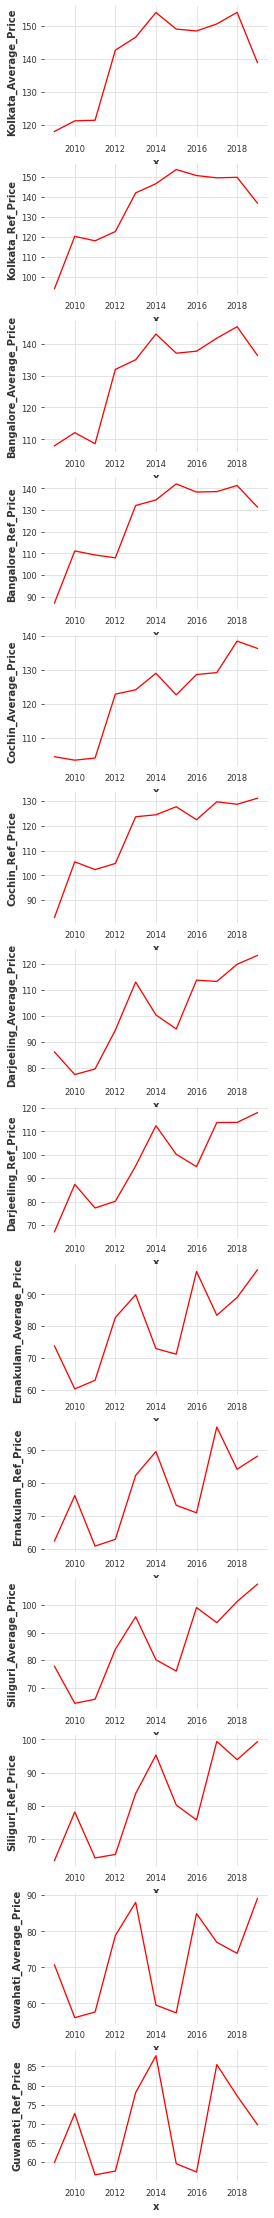

In [338]:
fig, ax = plt.subplots(14, figsize=(4,40 ))
train_by_year = train.groupby(train.WeekEnding_Date.map(lambda x: x.year)).mean()
for i in range(len(cols)):
    ax[i].plot(train_by_year.index.tolist(),train_by_year[cols[i]].tolist(),  c = 'red')
    ax[i].set_xlabel("x")
    ax[i].set_ylabel(str(cols[i]))



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.76636
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       874.195     0.0001125       67.4144      0.4312           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165        874.31   3.81986e-08       69.2802           1           1      217   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2019-02-11  149.415694  104.409652  166.217441   149.415694   149.415694   
1 2019-03-08  149.441703  102.790785  164.130833   149.441703   149.441703   
2 2019-05-10  149.507246  116.722322  178.584012   149.507246   149.507246   
3 2019-06-07  149.536376  117.546236  177.736741   149.536376   149.536376   
4 2019-06-15  149.544699  128.796628  186.624177   149.544699   149.544699   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0      -12.834372            -12.834372            -12.834372  3.589505   
1      -15.069751            -15.069751            -15.069751 -7.101504   
2       -1.982767             -1.982767             -1.982767 -7.101504   
3       -2.069251             -2.069251             -2.069251 -7.101504   
4        9.634117              9.634117              9.634117  3.442792   

   weekly_lower  weekly_upper     yearly  yearly_lower  yearly_upper  \
0      3

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2019-02-11  146.915843  100.952086  159.433055   146.915843   146.915843   
1 2019-03-08  146.815120  112.848499  171.628998   146.815120   146.815120   
2 2019-05-10  146.561298  118.547499  175.812487   146.561298   146.561298   
3 2019-06-07  146.448489  119.702962  179.995017   146.448489   146.448489   
4 2019-06-15  146.416257  125.447082  182.228266   146.416257   146.416257   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0      -17.426553            -17.426553            -17.426553  1.765673   
1       -5.373198             -5.373198             -5.373198 -1.939370   
2        0.168030              0.168030              0.168030 -1.939370   
3        2.836023              2.836023              2.836023 -1.939370   
4        6.948438              6.948438              6.948438  2.128517   

   weekly_lower  weekly_upper     yearly  yearly_lower  yearly_upper  \
0      1

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2019-02-11  141.879220   96.408958  156.757196   141.879220   141.879220   
1 2019-03-08  141.972186   94.403129  152.673319   141.972186   141.972186   
2 2019-05-10  142.206458  109.387016  170.827458   142.206458   142.206458   
3 2019-06-07  142.310580  113.992563  175.545332   142.310580   142.310580   
4 2019-06-15  142.340328  122.461647  184.479204   142.340328   142.340328   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0      -14.705915            -14.705915            -14.705915  1.141410   
1      -19.415425            -19.415425            -19.415425 -6.272449   
2       -3.431509             -3.431509             -3.431509 -6.272449   
3        3.722988              3.722988              3.722988 -6.272449   
4       12.395841             12.395841             12.395841  2.094997   

   weekly_lower  weekly_upper     yearly  yearly_lower  yearly_upper  \
0      1

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2019-02-11  139.244004   87.050466  149.609506   139.244004   139.244004   
1 2019-03-08  139.257331  103.225303  167.441398   139.257331   139.257331   
2 2019-05-10  139.290914  110.981007  172.205371   139.290914   139.290914   
3 2019-06-07  139.305840  119.834060  179.821442   139.305840   139.305840   
4 2019-06-15  139.310104  118.634251  178.485070   139.310104   139.310104   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0      -20.136793            -20.136793            -20.136793 -0.732639   
1       -4.062340             -4.062340             -4.062340  2.128748   
2        3.090358              3.090358              3.090358  2.128748   
3       11.127053             11.127053             11.127053  2.128748   
4       10.043774             10.043774             10.043774  1.756705   

   weekly_lower  weekly_upper     yearly  yearly_lower  yearly_upper  \
0     -0

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2019-02-11  135.452707   96.093202  141.183112   135.452707   135.452707   
1 2019-03-08  135.630683   99.339384  145.668207   135.630683   135.630683   
2 2019-05-10  136.079181  110.068045  156.994979   136.079181   136.079181   
3 2019-06-07  136.278513  117.727221  163.585206   136.278513   136.278513   
4 2019-06-15  136.335466  122.697282  169.820781   136.335466   136.335466   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0      -15.557211            -15.557211            -15.557211 -1.694285   
1      -13.668982            -13.668982            -13.668982 -5.506654   
2       -1.803909             -1.803909             -1.803909 -5.506654   
3        3.974365              3.974365              3.974365 -5.506654   
4        9.301502              9.301502              9.301502  1.231303   

   weekly_lower  weekly_upper     yearly  yearly_lower  yearly_upper  \
0     -1

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2019-02-11  130.016012   91.971519  137.593577   130.016012   130.016012   
1 2019-03-08  130.108445  100.835760  147.919032   130.108445   130.108445   
2 2019-05-10  130.341375  109.063187  155.603110   130.341375   130.341375   
3 2019-06-07  130.444900  118.515228  164.020338   130.444900   130.444900   
4 2019-06-15  130.474478  116.839892  162.893033   130.474478   130.474478   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0      -15.243233            -15.243233            -15.243233 -0.441325   
1       -5.492077             -5.492077             -5.492077 -0.014579   
2        2.116121              2.116121              2.116121 -0.014579   
3       10.368333             10.368333             10.368333 -0.014579   
4        7.928106              7.928106              7.928106 -0.022547   

   weekly_lower  weekly_upper     yearly  yearly_lower  yearly_upper  \
0     -0

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2019-02-11  122.901391  108.243475  134.799553   122.901391   122.901391   
1 2019-03-08  123.285040  114.155276  143.175890   123.285040   123.285040   
2 2019-05-10  124.251834  111.596678  140.349983   124.251834   124.251834   
3 2019-06-07  124.681520  112.362690  140.593300   124.681520   124.681520   
4 2019-06-15  124.804287  106.213407  137.016061   124.804287   124.804287   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0       -1.605905             -1.605905             -1.605905 -3.336487   
1        4.825481              4.825481              4.825481  2.628815   
2        2.742184              2.742184              2.742184  2.628815   
3        2.111075              2.111075              2.111075  2.628815   
4       -3.508051             -3.508051             -3.508051 -0.278442   

   weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0     -3.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2019-02-11  115.795042   99.698389  138.786218   115.795042   115.795042   
1 2019-03-08  116.074904   98.569443  138.672960   116.074904   116.074904   
2 2019-05-10  116.780156   99.688481  139.233416   116.780156   116.780156   
3 2019-06-07  117.093601   97.913523  138.663969   117.093601   117.093601   
4 2019-06-15  117.183157   93.924650  133.742313   117.183157   117.183157   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0        2.654035              2.654035              2.654035  2.671351   
1        2.966538              2.966538              2.966538  1.679683   
2        2.148934              2.148934              2.148934  1.679683   
3        1.381843              1.381843              1.381843  1.679683   
4       -2.990355             -2.990355             -2.990355 -0.415789   

   weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0      2.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2019-02-11  91.810857   70.009473  116.306652    91.810857    91.810857   
1 2019-03-08  91.978887   73.473201  120.293681    91.978887    91.978887   
2 2019-05-10  92.402324   71.406244  116.763249    92.402324    92.402324   
3 2019-06-07  92.590518   68.596377  118.360348    92.590518    92.590518   
4 2019-06-15  92.644287   65.893822  110.956100    92.644287    92.644287   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0        1.486563              1.486563              1.486563 -4.096569   
1        4.174191              4.174191              4.174191  2.220078   
2        1.680505              1.680505              1.680505  2.220078   
3        1.125778              1.125778              1.125778  2.220078   
4       -3.382942             -3.382942             -3.382942 -1.066755   

   weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0     -4.096569

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2019-02-11  88.119425   70.290286  114.346596    88.119425    88.119425   
1 2019-03-08  88.258010   72.082576  116.992926    88.258010    88.258010   
2 2019-05-10  88.607244   70.293743  114.529959    88.607244    88.607244   
3 2019-06-07  88.762459   70.999920  117.138165    88.762459    88.762459   
4 2019-06-15  88.806806   64.673417  109.571108    88.806806    88.806806   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0        4.099274              4.099274              4.099274  1.600611   
1        6.431652              6.431652              6.431652  4.686804   
2        4.512107              4.512107              4.512107  4.686804   
3        4.457125              4.457125              4.457125  4.686804   
4       -1.714166             -1.714166             -1.714166 -1.186423   

   weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0      1.600611

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2019-02-11  104.626717   88.160514  122.450404   104.626717   104.626717   
1 2019-03-08  104.996695   90.814586  126.169436   104.996695   104.996695   
2 2019-05-10  105.929039   89.839077  125.055120   105.929039   105.929039   
3 2019-06-07  106.343415   90.423382  126.574409   106.343415   106.343415   
4 2019-06-15  106.461807   88.244108  121.701223   106.461807   106.461807   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0        0.123998              0.123998              0.123998 -2.781555   
1        3.072896              3.072896              3.072896  2.043769   
2        1.300304              1.300304              1.300304  2.043769   
3        2.461540              2.461540              2.461540  2.043769   
4       -1.707411             -1.707411             -1.707411 -0.678100   

   weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0     -2.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2019-02-11  96.218663   77.591553  119.433328    96.218663    96.218663   
1 2019-03-08  96.420339   80.663531  122.130739    96.420339    96.420339   
2 2019-05-10  96.928563   80.129208  122.633707    96.928563    96.928563   
3 2019-06-07  97.154440   80.758146  120.593160    97.154440    97.154440   
4 2019-06-15  97.218976   75.513319  118.214086    97.218976    97.218976   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0        3.037493              3.037493              3.037493  2.040010   
1        4.497568              4.497568              4.497568  3.743121   
2        4.427305              4.427305              4.427305  3.743121   
3        4.001880              4.001880              4.001880  3.743121   
4       -0.774726             -0.774726             -0.774726 -0.554464   

   weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0      2.040010

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2019-02-11  79.135983   50.109748  104.845953    79.135983    79.135983   
1 2019-03-08  79.250270   57.188015  109.983453    79.250270    79.250270   
2 2019-05-10  79.538276   53.652311  109.303651    79.538276    79.538276   
3 2019-06-07  79.666278   55.583775  109.484044    79.666278    79.666278   
4 2019-06-15  79.702850   48.457290  103.291636    79.702850    79.702850   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0       -2.549408             -2.549408             -2.549408 -4.959356   
1        4.470764              4.470764              4.470764  2.911145   
2        2.567952              2.567952              2.567952  2.911145   
3        2.978356              2.978356              2.978356  2.911145   
4       -3.191019             -3.191019             -3.191019 -0.704767   

   weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0     -4.959356

          ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2019-02-11  75.251636   52.678999  103.179492    75.251636    75.251636   
1 2019-03-08  75.307532   56.345035  110.031162    75.307532    75.307532   
2 2019-05-10  75.448391   53.723436  104.784949    75.448391    75.448391   
3 2019-06-07  75.510995   52.924810  109.097474    75.510995    75.510995   
4 2019-06-15  75.528882   48.136696   98.857494    75.528882    75.528882   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0        2.469110              2.469110              2.469110  2.567795   
1        6.588464              6.588464              6.588464  5.240952   
2        5.358129              5.358129              5.358129  5.240952   
3        6.096458              6.096458              6.096458  5.240952   
4       -0.686471             -0.686471             -0.686471 -1.494185   

   weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0      2.567795

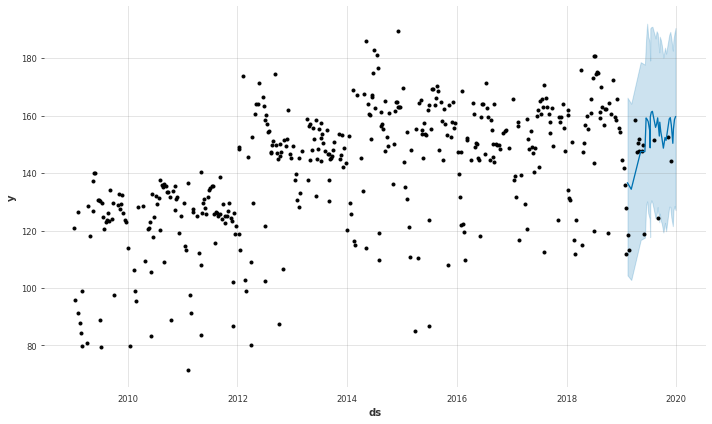

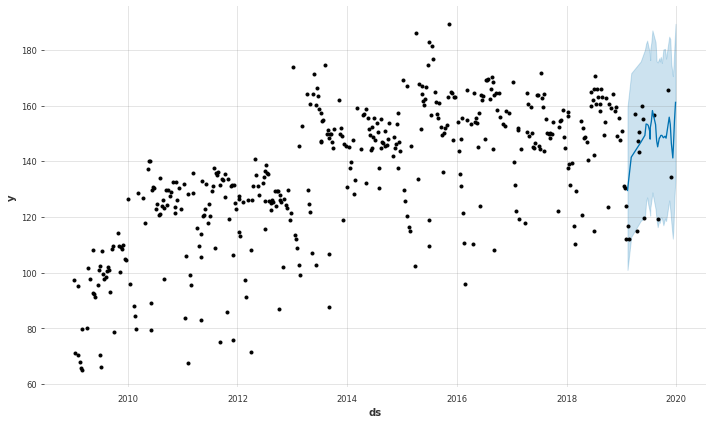

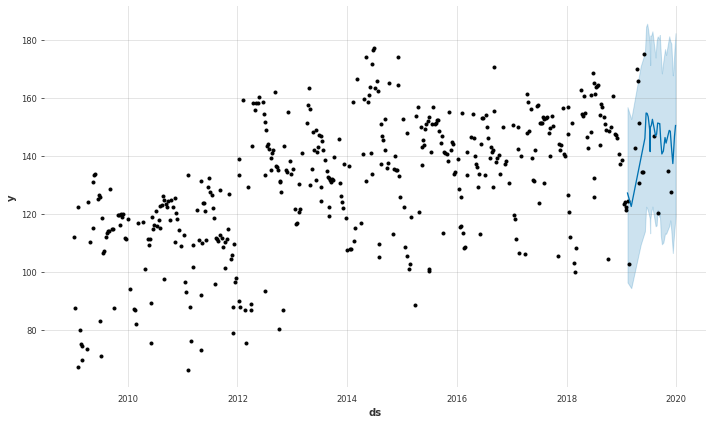

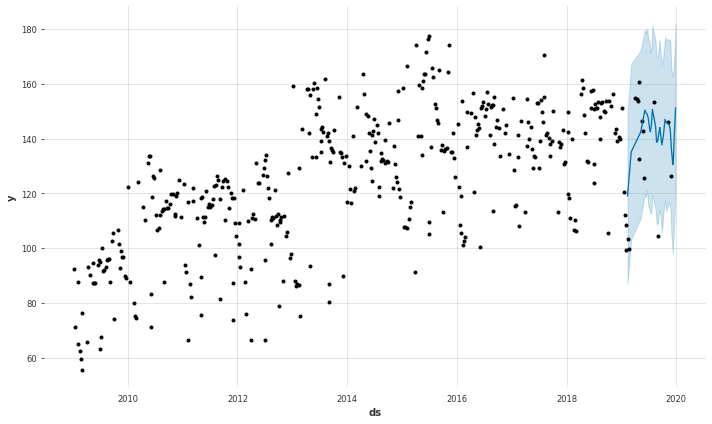

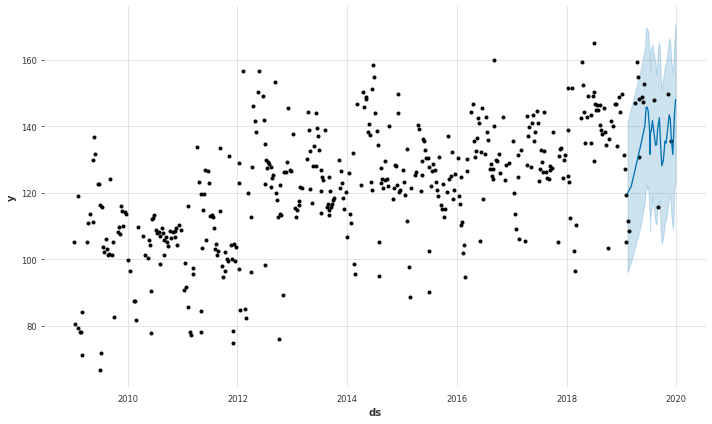

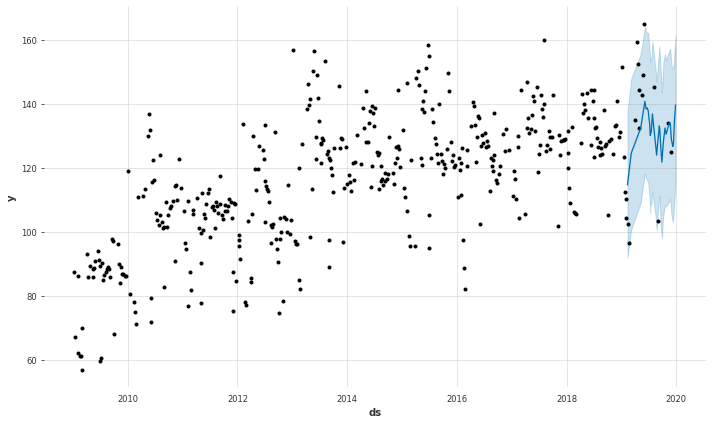

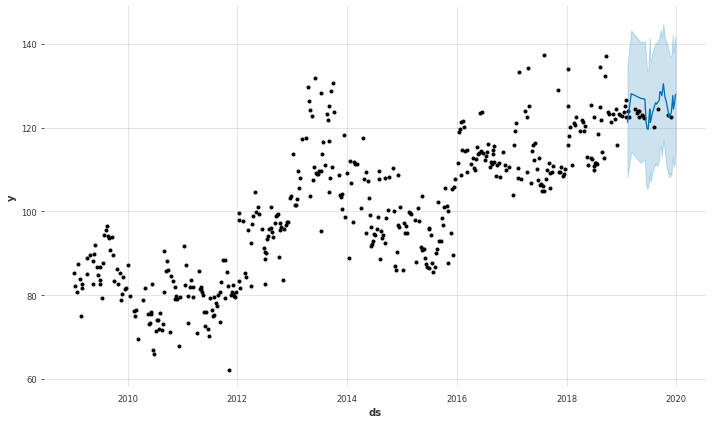

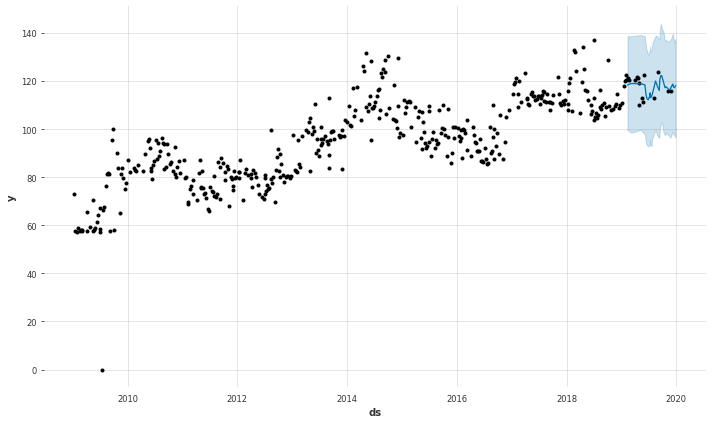

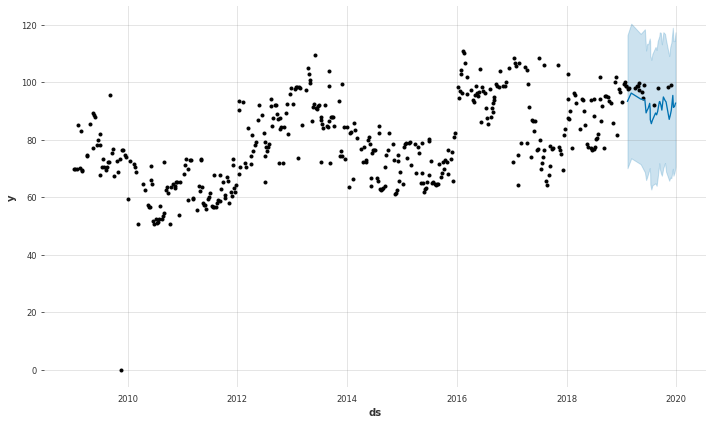

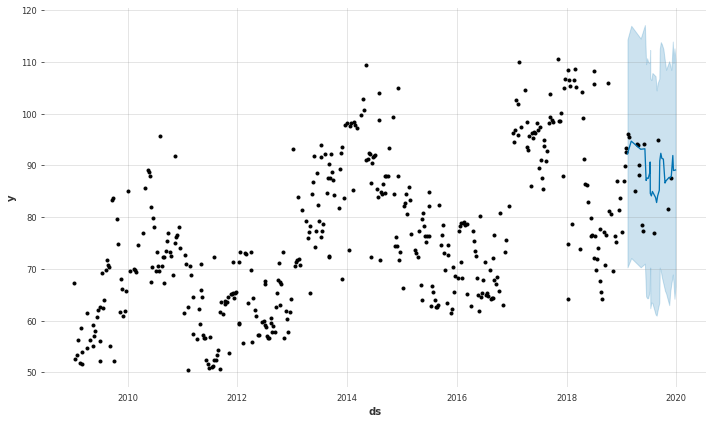

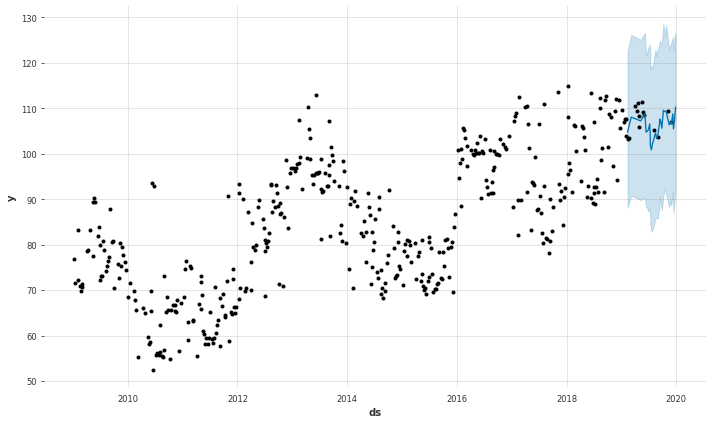

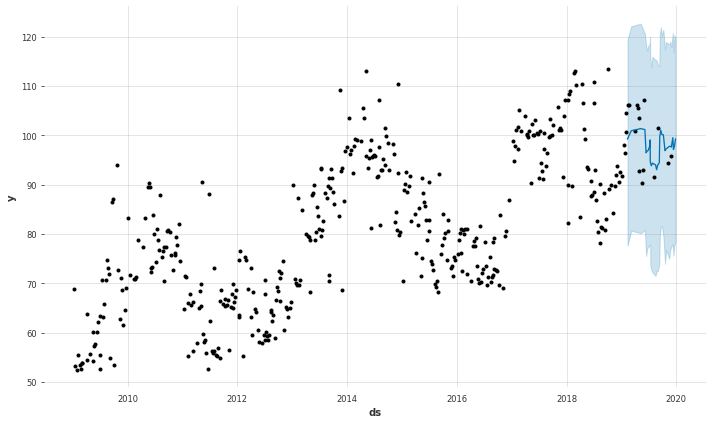

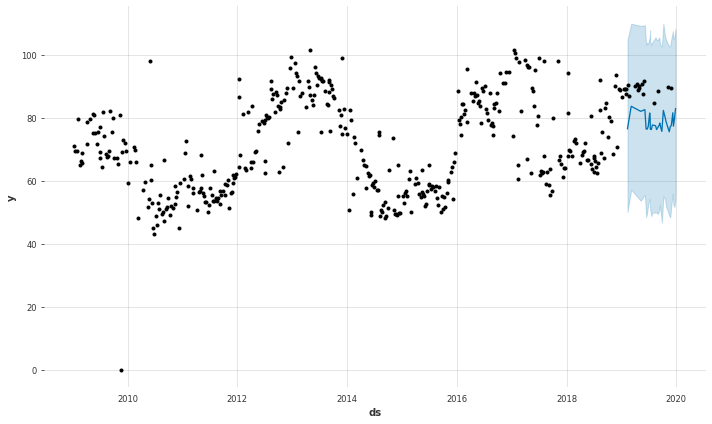

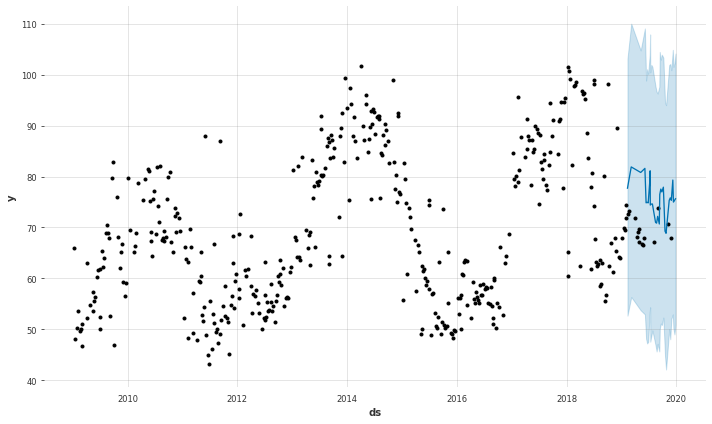

In [339]:

# series = {}
model = {}
prediction = {}
actual = {}


# df = train
for i in cols:
    df = train.loc[:,['WeekEnding_Date',i]]
    test_df = test.loc[:,['WeekEnding_Date',i]]
    df.columns = ['ds','y']
    test_df.columns = ['ds','y']
    model[i] = Prophet(interval_width=0.95)
#     series[i] = TimeSeries.from_dataframe(train,'WeekEnding_Date',i,fill_missing_dates=True,freq='W-SAT')
    tr, te = df,test_df
    tr.columns = ['ds','y']
    te.columns = ['ds','y']
#     model[i] = ExponentialSmoothing()
    model[i].fit(tr)
    prediction[i] = model[i].predict(te)
    model[i].plot(prediction[i])
    print(prediction[i].head())
    prediction[i] = prediction[i].loc[:,'trend'].values.tolist()
    actual[i] = te['y'].values.tolist()
    
#     prediction[i].plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
    plt.legend()


In [341]:
data = pd.DataFrame(actual)

In [342]:
data.head()

,Kolkata_Average_Price,Kolkata_Ref_Price,Bangalore_Average_Price,Bangalore_Ref_Price,Cochin_Average_Price,Cochin_Ref_Price,Darjeeling_Average_Price,Darjeeling_Ref_Price,Ernakulam_Average_Price,Ernakulam_Ref_Price,Siliguri_Average_Price,Siliguri_Ref_Price,Guwahati_Average_Price,Guwahati_Ref_Price
0,NaN,165.87,154.08,160.82,NaN,NaN,116.45,112.82,91.82,NaN,102.30,NaN,83.07,65.34
1,171.35,173.12,NaN,NaN,NaN,NaN,NaN,NaN,90.68,76.34,NaN,NaN,81.34,NaN
2,NaN,NaN,156.14,NaN,NaN,150.39,NaN,NaN,NaN,NaN,96.84,NaN,NaN,NaN
3,NaN,NaN,158.04,NaN,NaN,146.68,111.24,111.47,NaN,NaN,97.87,NaN,NaN,NaN
4,NaN,NaN,157.55,163.85,NaN,144.87,NaN,111.44,NaN,NaN,NaN,NaN,NaN,NaN


In [343]:
pred = pd.DataFrame(prediction)

In [344]:
pred.head()
avg = []
for i in range(len(data)):
    for j in range(len(data.iloc[i,:].values.tolist())):
        if np.isnan(data.iloc[i,j]):
            data.iloc[i,j] = pred.iloc[i,j]
    s =  sum([x for x in data.iloc[i,:].values.tolist()])/14
    avg.append(s)

In [345]:
avg

[117.98517868990338,
 118.27736819679899,
 117.76895894525292,
 116.46813618903742,
 119.6553084167332,
 113.85705255716405,
 117.32452818301786,
 119.15950346115675,
 120.19231579573572,
 118.4480789746548,
 115.73266582216766,
 116.02772712066862,
 118.75060455085229,
 115.64913985981205,
 118.33939011710409,
 119.18579698246745,
 117.15715187093794,
 119.61951021360845,
 116.48914364121522,
 118.26081496993345,
 116.4442529772823,
 116.42866835570824,
 115.97278291963087,
 117.7222451077405,
 118.70187469543252,
 118.16783447149544,
 117.21984127320147,
 118.26212066945496,
 115.96507715198038]

In [346]:
sum(pred.iloc[1,:].values.tolist())/14

115.6283675029578

In [347]:
from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
scaler = StandardScaler()
# X_train = [[day[i],month[i],year[i]] for i in range(len(train))]
train = train.iloc[:,[0,-1]]

X_train = train['WeekEnding_Date']
# X_train = train['WeekEnding_Date'].map(datetime.datetime.toordinal)
# X_train = np.array(X_train).reshape(-1, 1)

# X_train = np.array(X_train)
# X_train = scaler.fit_transform(X_train)

y_train = np.array(train.iloc[:,-1].values.tolist())
# y_train = np.array(train.iloc[:,1:].values.tolist())

# y_train = np.array(y_train).reshape(-1, 1)

## Now let us try the same using ARIMA

In [ ]:
test_stationarity(train['Average'])

In [ ]:
# X_test = [[day[i],month[i],year[i]] for i in range(len(test))]

X_test = test['WeekEnding_Date']#.map(datetime.datetime.toordinal)
# X_test = X_test.apply(lambda x:x)
X_test = np.array(X_test).reshape(-1, 1)

# X_test = np.array(X_test)
# X_test = scaler.fit_transform(X_test)

y_test = np.array(test.iloc[:,1:-1].values.tolist())
# y_test = np.array(test.iloc[:,1:-1].values.tolist())

# y_test = np.array(y_test).reshape(-1, 1)

In [ ]:
train

In [ ]:
train.index=train.WeekEnding_Date
train = train.loc[:,'Average']
plt.plot(train)

In [ ]:
ts_log = np.log(train)
plt.plot(ts_log)

In [ ]:
moving_avg =ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [ ]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

In [ ]:
ts_log_moving_avg_diff.dropna(inplace=True)
ts_log_moving_avg_diff.head()

In [ ]:
test_stationarity(ts_log_moving_avg_diff)

In [ ]:
expwighted_avg = ts_log.ewm(halflife=12,min_periods=0,adjust=True,ignore_na=False).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')
# expwighted_avg.plot(style='k--')

In [ ]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

In [ ]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

In [ ]:

ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf  

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [ ]:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

In [ ]:
model = ARIMA(ts_log, order=(5, 1, 0))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

In [ ]:
model = ARIMA(ts_log, order=(5,1,0))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [ ]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

In [ ]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

In [ ]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

In [ ]:
plt.plot(ts_log)
plt.plot(predictions_ARIMA_log)

In [ ]:
test.index=test.WeekEnding_Date
test = test.loc[:,'Average']

In [ ]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(train)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-train)**2)/len(train)))

In [ ]:

predictions = list()
X_test = test.index.values.tolist()
# walk-forward validation
for t in range(len(X_test)):
    model = ARIMA(train, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
#     history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

In [ ]:
# knn.fit(X_train, y_train)
# y_pred = knn.predict(X_test)

In [ ]:
predictions